In [3]:
# imports
from aerofoil2 import main_pontoon_calc
from aerofoil import calc_naca_area
from mech_module import *
from power_calcs import *


In [4]:
# define river speed and power requirements (the RPM is calculated from the river velocity)
river_vel = 1.025
turbine_width = 1.1
turbine_diameter = 1.1
pontoon_length = 1.8
foil_width = pontoon_length/4
t1 = 0.23 * pontoon_length
t2 = 0.12 * pontoon_length
r_drum = 0.425/2

print('blade area: ', str(turbine_width*(turbine_diameter/2 - r_drum)))

# define debris defence
block_t = 0.005
block_w = 0.022
block_spacing = 0.2
grid_offset = 0.3


blade area:  0.3712500000000001


Average river velocity: 1.0453 m/s


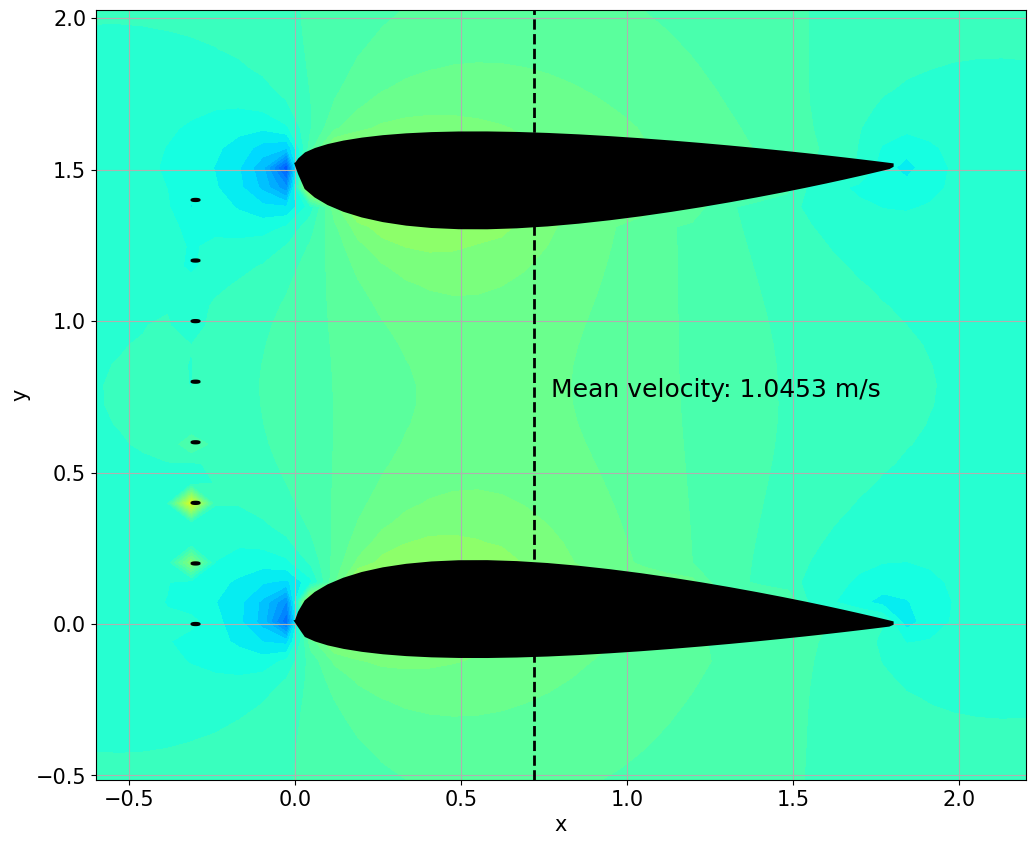

In [3]:
# apply effect of pontoons on river speed (calculate pontoon volume)
mean_pontoon_velocity = main_pontoon_calc(t1, t2, turbine_width, pontoon_length,river_vel,turbine_type=1,grid=True, block_t = block_t, block_w=block_w, grid_offset=grid_offset, block_round=True, block_spacing=block_spacing, plot=True)
river_vel = mean_pontoon_velocity

print("Average river velocity: %.4f m/s" %river_vel)

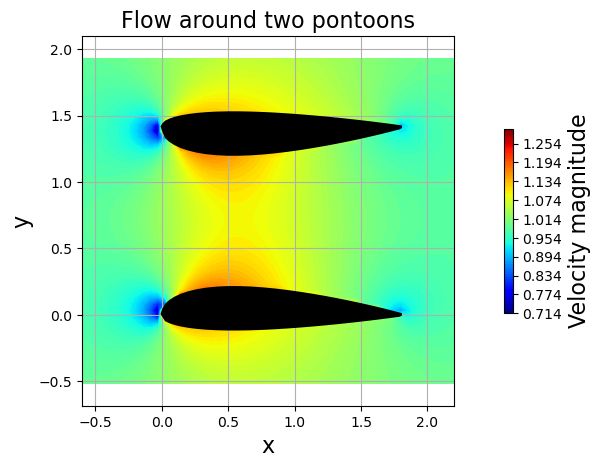

Average river velocity: 1.10 m/s


In [3]:
# apply effect of pontoons on river speed (calculate pontoon volume)
mean_pontoon_velocity = main_pontoon_calc(t1,t2, turbine_width, pontoon_length,river_vel,grid=False, block_t = block_t, block_w=block_w, grid_offset=grid_offset, block_round=True, block_spacing=block_spacing, plot=True)
river_vel = mean_pontoon_velocity
print("Average river velocity: %.2f m/s" %river_vel)

In [ ]:
# compare the effect of pontoon thickness and width on river speed
lengths = np.linspace(0.5, 2.5, 5)
widths = np.linspace(0.1, 0.6, 5)
river_vels = []
for l in lengths:
    for w in widths:
        river_vels.append(main_pontoon_calc(w, turbine_width, l, river_vel,grid=False, block_t = block_t, block_w=block_w, grid_offset=grid_offset, block_spacing=block_spacing, plot=False))

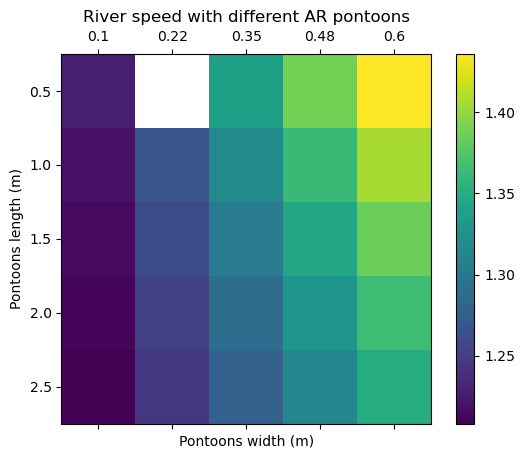

In [ ]:
# plot results as a heatmap with 20 colours
river_vels_plot = np.array(river_vels).reshape(5,5)
fig, ax = plt.subplots()
cax = ax.matshow(river_vels_plot, cmap='viridis')
fig.colorbar(cax)
ax.set_xticklabels(['']+list(np.round(widths,2)))
ax.set_yticklabels(['']+list(np.round(lengths,2)))
ax.set_xlabel('Pontoons width (m)')
ax.set_ylabel('Pontoons length (m)')
ax.set_title('River speed with different AR pontoons')
plt.show()

In [4]:
# Prototype calculations - ignore
pontoon_area = calc_naca_area(foil_width,pontoon_length)
mass = 125

pontoon_volume = mass / 1000
depth = pontoon_volume / pontoon_area

print('Minimum pontoon depth: %.2f m' %depth)



Minimum pontoon depth: 0.23 m


In [13]:
# calculate the area of the turbine
pontoon_area = calc_naca_area(foil_width, pontoon_length)

In [6]:
# calculate the drag force on the pontoon
worst_case = 4
front_area = (pontoon_height * pontoon_width * 2) + (turbine_width * turbine_diameter/2 )
pontoon_drag = 0.5 * 1000 * worst_case**2 * 1.28 * front_area
print('Pontoons drag = ', pontoon_drag, 'N')

NameError: name 'pontoon_height' is not defined

In [7]:
print('Pontoon area: ', pontoon_area)
print('Mean pontoon velocity: ', mean_pontoon_velocity)

Pontoon area:  0.5544025350846892
Mean pontoon velocity:  1.1374458856444594


In [26]:
# how tall do the pontoons need to be to support the turbine?
turbine_mass = 100
pontoon_height = pontoon_height_calc(pontoon_area, turbine_mass)
print('Pontoon height: ', pontoon_height)

Pontoon height:  0.09018717779196685


In [7]:
def rpm_calc(velocity, radius, tsr):
    return (60*tsr*velocity)/(np.pi*radius)

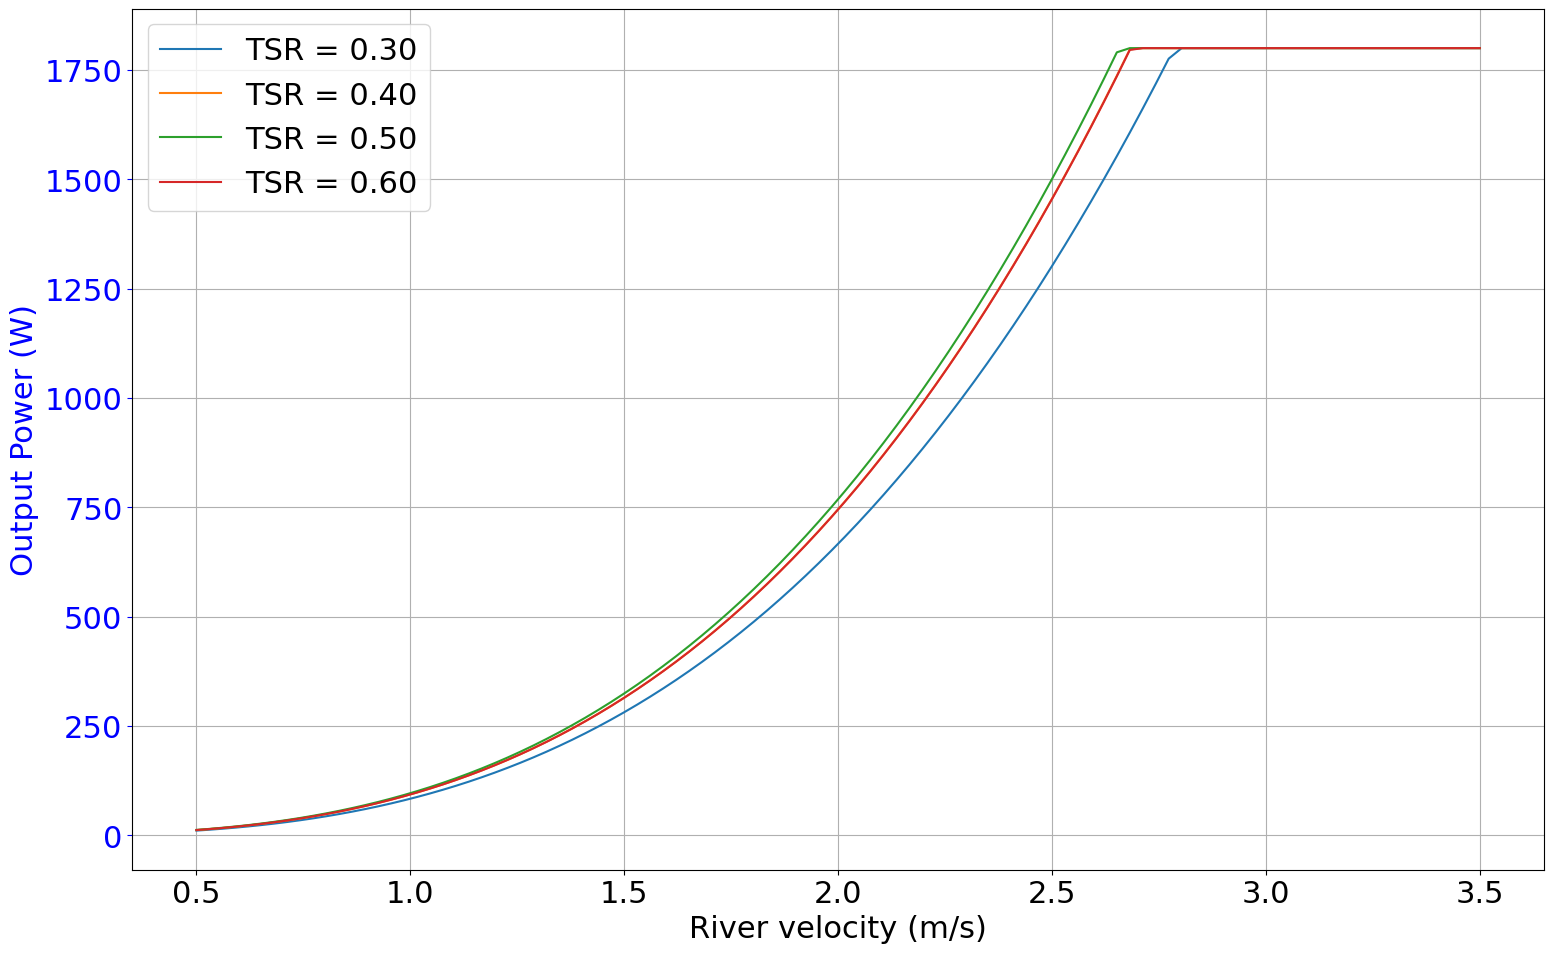

In [29]:

# plot power vs velocity and efficiency vs velocity on the same plot
fig, ax = plt.subplots(figsize=(16,10))
plt.rcParams.update({'font.size': 22})

# calculate RPM (using the velocity model for shaft power output)
v = np.linspace(0.5,3.5,100)


for tsr in np.linspace(0.3, 0.6, 4):


    rpm = rpm_calc(v, turbine_diameter/2, tsr)
    p_array = power(v*1.15, runner_diameter=turbine_diameter, r_drum=r_drum, L=turbine_width/2, RPM=rpm)

    # max power is 1800W, set max power to 1800W
    p_array[p_array>1800] = 1800


    max_power_array = []
    # compare to the power of that flow to get the efficiency
    blade_area = ((turbine_diameter/2) - r_drum) * turbine_width
    for i in range(len(v)):
        p, _,_,_,_ = power_calc(efficiency=1,V=v[i],A=blade_area)
        max_power_array.append(p)

    # overall efficiency
    eff = p_array/max_power_array
    efficiency = max(eff)


    ax.plot(v,p_array, label='TSR = %.2f' %tsr, ls='-')
ax.set_xlabel('River velocity (m/s)', fontsize=22)
# set font for all text in figure
plt.grid()
ax.set_ylabel('Output Power (W)', color='b', fontsize=22)
ax.tick_params('y', colors='b')
# ax1.set_title('Power and Efficiency vs River Velocity @ 20RPM')
# ax1.legend(loc='lower right', fontsize=15)

# ax2 = ax1.twinx()
# ax2.plot(v,eff, label='Efficiency', color='r')
# ax2.set_ylabel('Efficiency', color='r', fontsize=15)
# ax2.tick_params('y', colors='r')
# ax2.legend(loc='lower right + 1', fontsize=15)

# combine legends
# lines, labels = ax1.get_legend_handles_labels()
# # lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='lower right')

plt.legend()


fig.tight_layout()
plt.show()





In [5]:
# with the RPM, power requirements, river velocity, and efficiency estimates for components
# calculate base dimensions for the turbine (width and radius of the turbine) (calculate rough volume of the turbine)

# set RPM to the max power RPM
RPM = 20

# estimate the efficiency of the turbine
generator_eff = 0.5
gearbox_eff = 1
drive_efficiency = generator_eff * gearbox_eff
print('Drive efficiency: ', drive_efficiency)

# hydro efficiency is calculated above as 0.12

# power required = 400w
power_required = 200
efficiency = efficiency * drive_efficiency
print('Overall Efficiency: ', efficiency)

# calculate the area required for the turbine
_, _, _, area, _ = power_calc(efficiency=efficiency,V=1.5,P=power_required)
print('Area required (m^2): ', area)


Drive efficiency:  0.5


NameError: name 'efficiency' is not defined

In [12]:
# using the above calculate the required blade thickness (with additional input of material properties)
# define the material properties
sigma_y = 22e6
worst_case_vel = 3.5
sf = 1.5
thickness = minimum_blade_thickness(sigma_y, worst_case_vel*sf, turbine_width/2, r_drum, rho=1000, RPM=RPM,CD = 1.28)
print('Blade thickness (mm): ', thickness)

Blade thickness (mm):  10.078929356931052


In [13]:
# run the debris impact model to determine worst case debris size and impact force
# define the material properties
impact_toughness = 2.6 # J/cm^2
size = debris_calc(impact_toughness, thickness, worst_case_vel)
print('Debris length size (mm): ', size)


Debris length size (mm):  400.4220129470406


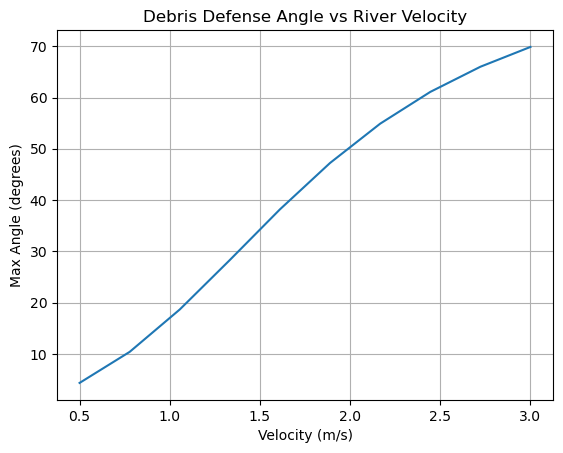

In [14]:
# calculate the angle of the debris defense system to send debris under the turbine
angles = []
velocities = np.linspace(0.5, 3,10 )
for u in velocities:
    angles.append(-debris_angle(u, size/1000 ))

# plot the angle vs velocity
plt.plot(velocities, angles)
plt.grid()
plt.xlabel('Velocity (m/s)')
plt.ylabel('Max Angle (degrees)')
plt.title('Debris Defense Angle vs River Velocity')
plt.show()


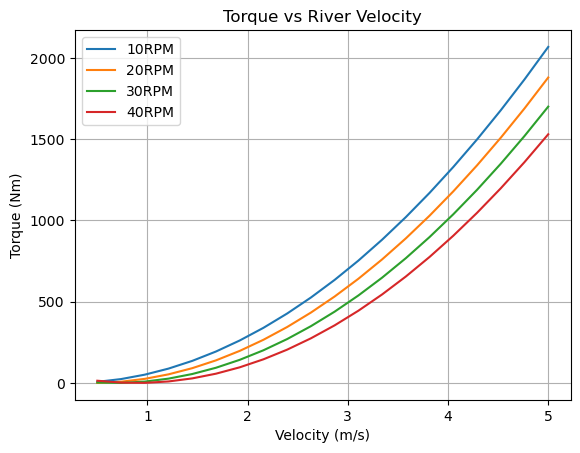

Worst case torque (Nm):  2067.5323829462295


In [6]:
# using dimensions and inputs calculate the torque on the drive shaft

# calculate the torque on the drive shaft
vs = np.linspace(0.5,5,20)
torques10 = []
torques20 = []
torques30 = []
torques40 = []
for v in vs:
    torques10.append(torque(v,turbine_diameter,r_drum, turbine_width/2,10))
    torques20.append(torque(v,turbine_diameter,r_drum, turbine_width/2,20))
    torques30.append(torque(v,turbine_diameter,r_drum, turbine_width/2,30))
    torques40.append(torque(v,turbine_diameter,r_drum, turbine_width/2,40))

# plot the torque vs velocity
plt.plot(vs, torques10, label='10RPM')
plt.plot(vs, torques20, label='20RPM')
plt.plot(vs, torques30, label='30RPM')
plt.plot(vs, torques40, label='40RPM')
plt.grid()
plt.xlabel('Velocity (m/s)')
plt.ylabel('Torque (Nm)')
plt.title('Torque vs River Velocity')
plt.legend()
plt.show()

print('Worst case torque (Nm): ', torques10[-1])

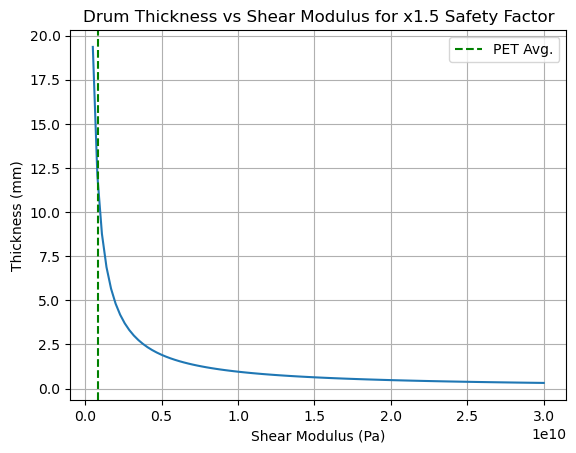

In [23]:
# drum calculations
thickness, shear_strength_mpa, yield_strength_mpa, shear_mod, cost = drum_calc(G=26.5e9, w=3229, l_blade=0.6, l_drum = 1.2, R=200e-3, rho_mat = 2910, cpkg = 3.04)

# plot G vs thickness
Gs = np.linspace(0.5e9, 30e9, 100)
thicknesses = []
for g in Gs:
    val,_,_,_,_ = drum_calc(G=g, w=3229, l_blade=0.6, l_drum = 1.2, R=200e-3, rho_mat = 2910, cpkg = 3.04)
    thicknesses.append(val)

plt.plot(Gs,thicknesses)
plt.xlabel('Shear Modulus (Pa)')
plt.ylabel('Thickness (mm)')
plt.grid()
# plot vertical line at G = 26.5GPa for Aluminium
# plt.axvline(x=26.5e9/1.5, color='r', linestyle='--', label='Aluminium Avg.')
plt.axvline(x=1.242e9/1.5, color='g', linestyle='--', label='PET Avg.')
# plt.axvline(x=0.266e9/1.5, color='b', linestyle='--', label='HDPE Avg.')
# plt.axvline(x=0.8635e9/1.5, color='y', linestyle='--', label='ABS Avg.')
plt.legend()
plt.title('Drum Thickness vs Shear Modulus for x1.5 Safety Factor')
plt.show()



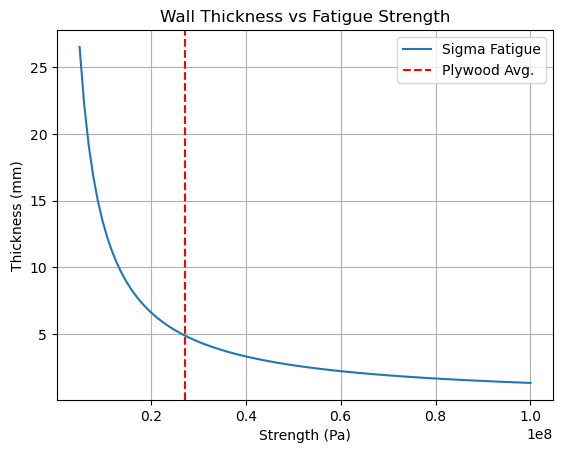

In [26]:
# wall thickness calculation
t_req, yield_strength_mpa, shear_strength_mpa, cost_wall = wall_calc(worst_case_v = 3.5, l_wall = 425e-3, h = 165e-3, sigma_fat = 27.25e6, tau_mod = 0.8505e9, rho_mat = 1200, cpkg = 2.865)

# plot sigma fatigue and sheer modulus vs thickness
sigmas = np.linspace(5e6, 100e6, 100)
thicknesses1 = []
for s in sigmas:
    val,_,_,_ = wall_calc(worst_case_v = 3.5,  sigma_fat =s, tau_mod=np.nan)
    thicknesses1.append(val* 1000)


plt.plot(sigmas, thicknesses1 , label='Sigma Fatigue')

# line at 27.1MPa
plt.axvline(x=27.25e6, color='r', linestyle='--', label='Plywood Avg.')
plt.xlabel('Strength (Pa)')
plt.ylabel('Thickness (mm)')
plt.grid()
plt.legend()
plt.title('Wall Thickness vs Fatigue Strength')
plt.show()


Text(0.5, 1.0, 'Wall Thickness vs Shear Modulus')

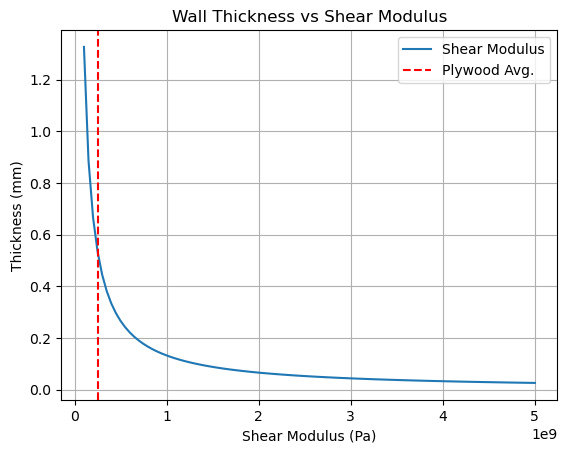

In [30]:

tau_mods = np.linspace(0.1e9, 5e9, 100)
thicknesses2 = []

for t in tau_mods:
    val,_,_,_ = wall_calc(worst_case_v = 3.5,tau_mod = t, sigma_fat=t)
    thicknesses2.append(val * 1000)

plt.plot(tau_mods, thicknesses2, label='Shear Modulus')
# ply line at 0.25MPa
plt.axvline(x=0.25e9, color='r', linestyle='--', label='Plywood Avg.')
plt.xlabel('Shear Modulus (Pa)')
plt.ylabel('Thickness (mm)')
plt.grid()
plt.legend()
plt.title('Wall Thickness vs Shear Modulus')


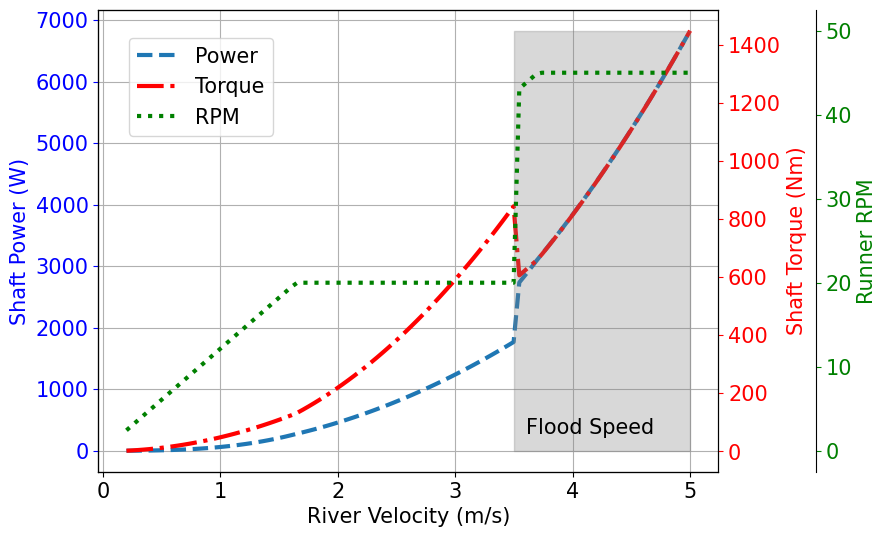

In [33]:
# linking power, torque, speed, RPM into a table based on river velocities.
# the RPM will aim to be 20RPM

# RPM calculation
RPMs = []
torques = []
powers = []

# optimal tip speed ratio
TSR = 0.7

def calc_RPM(v, TSR):
    rpm = (TSR * v / (turbine_diameter/2)) * 60 / (2 * np.pi)
    if rpm > 20 and v < 3.5:
        rpm = 20
    elif rpm > 45:
        rpm = 45
    return rpm

velocity_range = np.linspace(0.2, 5, 100)
for v in velocity_range:
    RPM = calc_RPM(v, TSR)
    RPMs.append(RPM)
    powers.append(power(v, runner_diameter=turbine_diameter, r_drum=r_drum, L=turbine_width/2, RPM=RPM))
    torques.append(torque(v, turbine_diameter, r_drum, turbine_width/2, RPM))

# plot the power, torque, and RPM vs velocity
fig, ax1 = plt.subplots(figsize=(8,6))
plt.rcParams.update({'font.size': 15})
ax1.plot(velocity_range, powers, label='Power', linestyle='--', linewidth=3)
ax1.set_xlabel('River Velocity (m/s)',  fontsize = '15')
plt.grid()
ax1.set_ylabel('Shaft Power (W)', color='b',  fontsize = '15')
ax1.tick_params('y', colors='b')
# ax1.set_title('Power, Torque, and RPM vs River Velocity')


ax2 = ax1.twinx()
ax2.plot(velocity_range, torques, label='Torque', color='r', linestyle='-.', linewidth=3)
ax2.set_ylabel('Shaft Torque (Nm)', color='r',  fontsize = '15')
ax2.tick_params('y', colors='r')
# ax2.grid(ls='-.')


# space for RPM
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 70))
ax3.plot(velocity_range, RPMs, label='RPM', color='g', linestyle=':', linewidth=3)
ax3.set_ylabel('Runner RPM', color='g',  fontsize = '15')
ax3.tick_params('y', colors='g')
# ax3.grid(ls='--')

# shade in the region of the graph above 3.5m/s and label it flood
plt.fill_betweenx(np.linspace(0, 50, 30), 3.5, 5, color='grey', alpha=0.3)
plt.text(3.6, 2, 'Flood Speed', fontsize=15, color='black')

# place legend inside plot upper left
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.85), fontsize = '15')
# fig.tight_layout()
plt.show()

